In [1]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax
from jax import random

from flax import linen as nn
from einops import rearrange
import optax
import tensorflow as tf
from tqdm import trange
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_probability.substrates.jax as tfp

# Ensure TF does not see GPU and grab all GPU memory
tf.config.experimental.set_visible_devices([], "GPU")

from cosmos_data import read_data

# Loading the COSMOS Dataset of galaxy images

#TODO: add info on dataset

In [2]:
n_pixels = 32
x = read_data('data/COSMOS_23.5_training_sample/', n_pixels=n_pixels,)

0it [00:00, ?it/s]

  0%|          | 0/56062 [00:00<?, ?it/s]

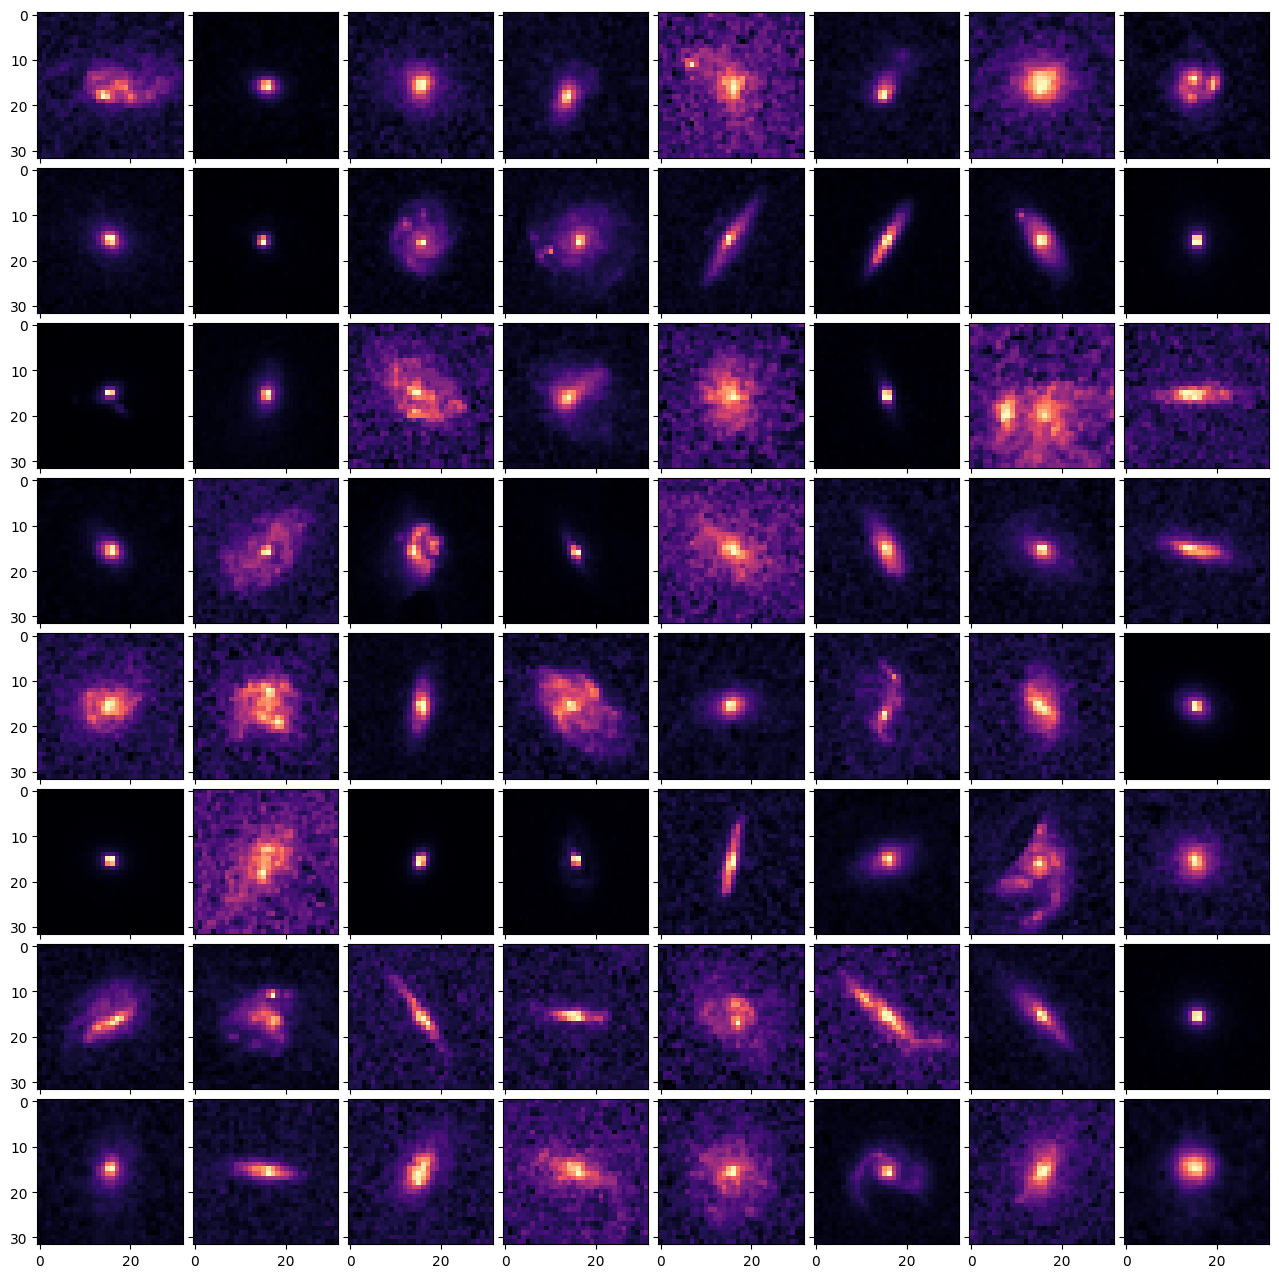

In [3]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(16., 16.))

grid = ImageGrid(fig, 111, nrows_ncols=(8, 8),axes_pad=0.1,)

for ax, im in zip(grid, x[np.random.randint(len(x), size=64)]):
    ax.imshow(im, cmap='magma')

In [4]:
# Add channel dimension
x = x[..., None]
# Normalize pixel values between 0 and 1
x_min = x.min()
x_max = x.max()

x = (x - x_min) / (x_max - x_min)

In [5]:
class MLP(nn.Module):
    """ A simple MLP, used for the encoder and decoder.
    """
    hidden_dim: int = 256
    out_dim: int = 2
    n_layers: int = 4

    @nn.compact
    def __call__(self, x):
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.hidden_dim)(x)
            x = nn.gelu(x)
        x = nn.Dense(features=self.out_dim)(x)
        return x


In [20]:
class VAE(nn.Module):
    """ A simple variational auto-encoder module.
    """
    num_latents: int = 64 
    num_out: int = 2

    def setup(self):
        self.encoder = MLP(out_dim=self.num_latents * 2)
        self.decoder = MLP(out_dim=n_pixels*n_pixels)

    def __call__(self, x, z_rng):
        # Flatten x
        x = rearrange(x, 'b h w c -> b (h w c)')
        # Get variational parameters from encoder
        enc = self.encoder(x)  # Shape (batch_size, num_latents * 2)
        enc = rearrange(enc, 'b (n c) -> b n c', c=2)  # Reshape to (batch_size, num_latents, 2)
        mu, logvar = enc[:, :, 0], enc[:, :, 1]

        # Sample from variational distrib. of latents
        z = tfp.distributions.Normal(loc=mu, scale=jnp.exp(0.5 * logvar)).sample(seed=z_rng)
        # Decode
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

@jax.vmap
def rate(mu, logvar):
    """ KL-divergence between latent variational distribution and unit Normal prior.
    """
    prior_latent = tfp.distributions.Normal(loc=0., scale=1.)  # Prior
    q_latent = tfp.distributions.Normal(loc=mu, scale=jnp.exp(0.5 * logvar))  # Variational latent distrib.
    return tfp.distributions.kl_divergence(q_latent, prior_latent)

@jax.vmap
def distortion(pred, true, ):
    """ "Reconstruction" loss, Gaussian noise model.
    """
    true = rearrange(true, 'h w c -> (h w c)')
    # normalize between 0 and 1
    pred = nn.sigmoid(pred)
    log_prob = tfp.distributions.Normal(loc=pred, scale=0.01).unnormalized_log_prob(true)
    return -log_prob

from functools import partial

@partial(jax.jit, static_argnums=(1,))
def loss_fn(params, vae, x_batch, z_rng):
    """ Loss function for the VAE, rate + distortion.
    """
    recon_x, mean, logvar = vae.apply(params, x_batch, z_rng)
    R = rate(mean, logvar,).mean(-1)
    D = distortion(recon_x, x_batch,).mean(-1)
    loss = D + R
    return loss.mean()

In [29]:
num_latents = 64 
num_out = n_pixels * n_pixels

vae = VAE(num_latents=num_latents, num_out=num_out,)

key = jax.random.PRNGKey(42)
key, z_key = random.split(key)
_, params = vae.init_with_output(key, x[:16],  z_key)

In [30]:
num_out

1024

In [31]:
print(loss_fn(params, vae, x[:128],  key))

1196.0756


In [32]:
n_steps = 2_000 
n_batch = 512

opt = optax.adam(learning_rate=4e-4)
opt_state = opt.init(params)

with trange(n_steps) as steps:
    for step in steps:

        # Draw a random batches from x
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(n_batch,))
        
        x_batch = x[idx]

        # Draw random batch of betas
        key, subkey = jax.random.split(key)

        # Get loss and update
        loss, grads = jax.value_and_grad(loss_fn)(params, vae, x_batch, key)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(val=loss)

100%|██████████| 2000/2000 [01:05<00:00, 30.55it/s, val=-3.4982994]


In [33]:

key, subkey = jax.random.split(key)
recon_x, mean, logvar = vae.apply(params, x_batch, key)

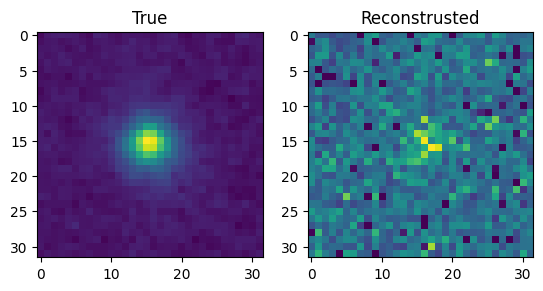

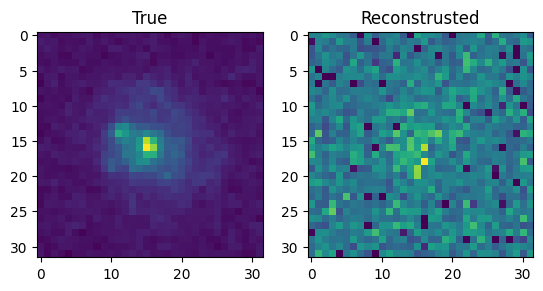

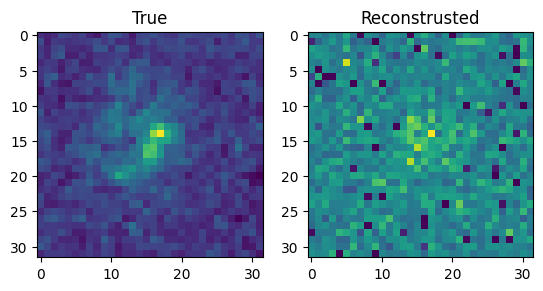

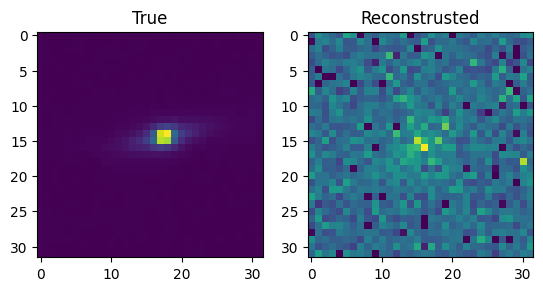

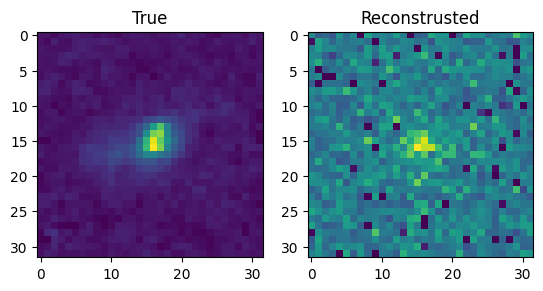

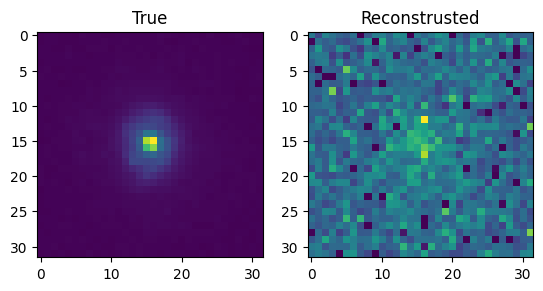

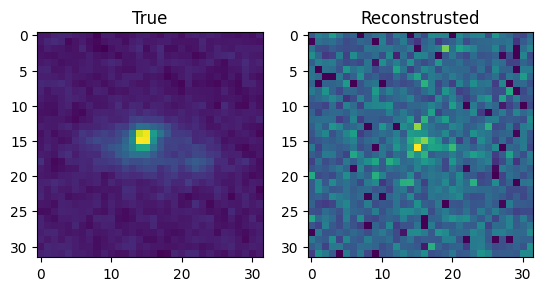

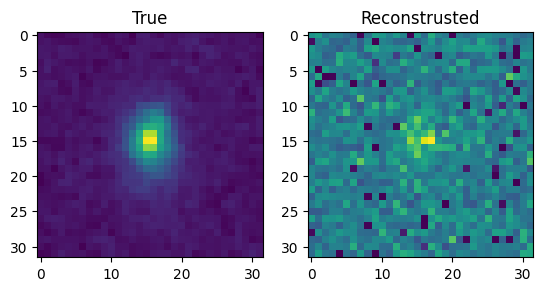

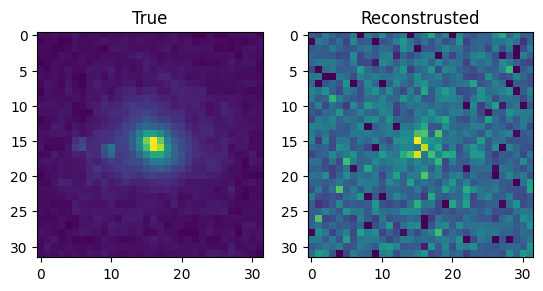

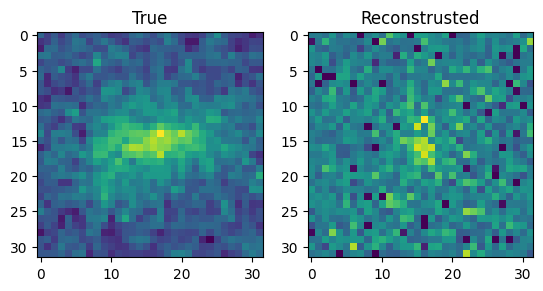

In [34]:
for i in range(10):
    fig, ax = plt.subplots(ncols=2)
    ax[0].imshow(x_batch[i])
    ax[1].imshow(nn.sigmoid(recon_x[i].reshape(n_pixels, n_pixels)))
    ax[0].set_title('True')
    ax[1].set_title('Reconstrusted')
    plt.show()

## Generating samples

In [35]:
@jax.jit
def eval(params, z):
    """ Generate sample for a latent code z.
    """
    def eval_model(vae):
        return vae.decoder(z)
    return nn.sigmoid(nn.apply(eval_model, vae)(params))

z = jax.random.normal(key, shape=(16, num_latents))
x_samples = eval(params, z)

# Draw samples from model
x_samples = rearrange(x_samples, 'b (h w c) -> b h w c', h=n_pixels, w=n_pixels, c=1)

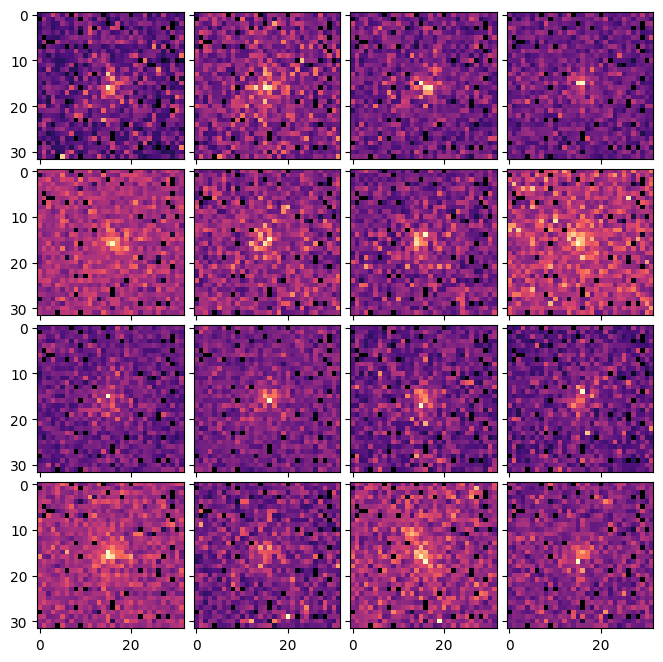

In [36]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(8., 8.))

grid = ImageGrid(fig, 111, nrows_ncols=(4, 4),axes_pad=0.1,)

for ax, im in zip(grid, x_samples[..., 0]):
    ax.imshow(im, cmap='magma')

In [59]:
# find low likelihood images vs high likelihood images

In [ ]:
# exploring latent space vs physical parameters

In [ ]:
# how good is your model? Train classifier to distinguish real from generated